In [9]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, hour, to_timestamp, when
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import json

# 1. Start Spark session
spark = SparkSession.builder \
    .appName("BirdPresencePrediction") \
    .getOrCreate()

# 2. Load JSON data
df = spark.read.option("multiline", "true").json("birdsdetection11Tage.json")

# 3. Choose species of interest (e.g., European Greenfinch, id = 294)
TARGET_SPECIES_ID = 294

# 4. Extract relevant fields and create label column
data = df.select(
    col("timestamp"),
    col("species.id").alias("species_id")
).withColumn(
    "label", when(col("species_id") == TARGET_SPECIES_ID, 1).otherwise(0)
).withColumn(
    "hour_of_day", hour(to_timestamp("timestamp"))
).dropna(subset=["hour_of_day"])

# 5. Feature assembler
assembler = VectorAssembler(
    inputCols=["hour_of_day"],
    outputCol="features"
)
feature_data = assembler.transform(data)

# 6. Train/test split
train_data, test_data = feature_data.randomSplit([0.8, 0.2], seed=42)

train_data.groupBy("label").count().show()

# 7. Logistic Regression model
lr = LogisticRegression(featuresCol="features", labelCol="label")
model = lr.fit(train_data)

# 8. Evaluate model
predictions = model.transform(test_data)
evaluator = BinaryClassificationEvaluator()
auc = evaluator.evaluate(predictions)

print(f"Model AUC: {auc:.3f}")

# Optional: Show example predictions
predictions.select("hour_of_day", "label", "prediction", "probability").show(10)

# 9. Stop Spark session when done
spark.stop()

+-----+-----+
|label|count|
+-----+-----+
|    1|   10|
|    0|  159|
+-----+-----+

Model AUC: 0.929
+-----------+-----+----------+--------------------+
|hour_of_day|label|prediction|         probability|
+-----------+-----+----------+--------------------+
|         14|    1|       0.0|[0.58333333333368...|
|         14|    1|       0.0|[0.58333333333368...|
|         14|    1|       0.0|[0.58333333333368...|
|         14|    0|       0.0|[0.58333333333368...|
|         14|    0|       0.0|[0.58333333333368...|
|         14|    0|       0.0|[0.58333333333368...|
|         14|    0|       0.0|[0.58333333333368...|
|         15|    0|       0.0|[0.99999979489710...|
|         15|    0|       0.0|[0.99999979489710...|
|         15|    0|       0.0|[0.99999979489710...|
+-----------+-----+----------+--------------------+
only showing top 10 rows



In [21]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, hour, dayofweek, to_timestamp, lit, explode, collect_set
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.types import StructType, StructField, StringType, FloatType, IntegerType, TimestampType, DoubleType
import json

# 1. Start Spark session
spark = SparkSession.builder.appName("BirdSpeciesPresenceByTime").getOrCreate()

# 2. Load the JSON data
df_raw = spark.read.option("multiline", "true").json("birdsdetection11Tage_backup.json")

# 3. Extract time-based features and species
df = df_raw.withColumn("timestamp", to_timestamp("timestamp")) \
    .withColumn("hour", hour("timestamp")) \
    .withColumn("speciesId", col("species.id")) \
    .withColumn("speciesName", col("species.commonName"))
    #.withColumn("day_of_week", dayofweek("timestamp")) \
    #.withColumn("speciesId", col("species.id")) \
    #.withColumn("speciesName", col("species.commonName"))

# 4. Get unique hours and days to create negative samples
#time_combinations = df.select("hour", "day_of_week").distinct()
time_combinations = df.select("hour").distinct()

# 5. Get all distinct species
species_list = df.select("speciesId", "speciesName").distinct().collect()

results = []

for row in species_list:
    species_id = row["speciesId"]
    species_name = row["speciesName"]
    
    # Positive samples for this species
    df_pos_raw = df.filter(col("speciesId") == species_id) \
                .select("hour") \
                .distinct()
               #.select("hour", "day_of_week") \
                #.select("hour") \
               #.distinct()
    
    # Negative samples = time slots where this species was NOT seen
    df_neg = time_combinations.subtract(df_pos_raw)

    # Now add labels
    df_pos = df_pos_raw.withColumn("label", lit(1))
    df_neg = df_neg.withColumn("label", lit(0))
    
    # Combine both
    df_model = df_pos.union(df_neg)
    
    # Assemble features
    #assembler = VectorAssembler(inputCols=["hour", "day_of_week"], outputCol="features")
    assembler = VectorAssembler(inputCols=["hour"], outputCol="features")
    df_model = assembler.transform(df_model)
    
    # Train logistic regression
    lr = LogisticRegression(featuresCol="features", labelCol="label")
    model = lr.fit(df_model)
    
    # Make predictions
    #predictions = model.transform(df_model).select("hour", "day_of_week", "label", "prediction", "probability")
    predictions = model.transform(df_model).select("hour", "label", "prediction", "probability")
    
    # Collect for inspection or saving
    results.append((species_name, predictions))

    #print(f"✅ Trained model for {species_name}")

# Example: Show predictions for the first species
species_name, predictions_df = results[0]
print(f"\n🔍 Sample predictions for '{species_name}':")
#predictions_df.orderBy("hour", "day_of_week").show(10)
predictions_df.orderBy("hour").show(10)


🔍 Sample predictions for 'Crested Tit':
+----+-----+----------+--------------------+
|hour|label|prediction|         probability|
+----+-----+----------+--------------------+
|   0|    0|       0.0|[0.56241842097094...|
|   1|    0|       0.0|[0.59789104416322...|
|   2|    0|       0.0|[0.63236774346765...|
|   3|    0|       0.0|[0.66554200844927...|
|   4|    0|       0.0|[0.69715633858777...|
|   5|    1|       0.0|[0.72700810016342...|
|   6|    1|       0.0|[0.75495161990750...|
|   7|    1|       0.0|[0.78089686277394...|
|   8|    1|       0.0|[0.80480532614158...|
|   9|    0|       0.0|[0.82668393414550...|
+----+-----+----------+--------------------+
only showing top 10 rows



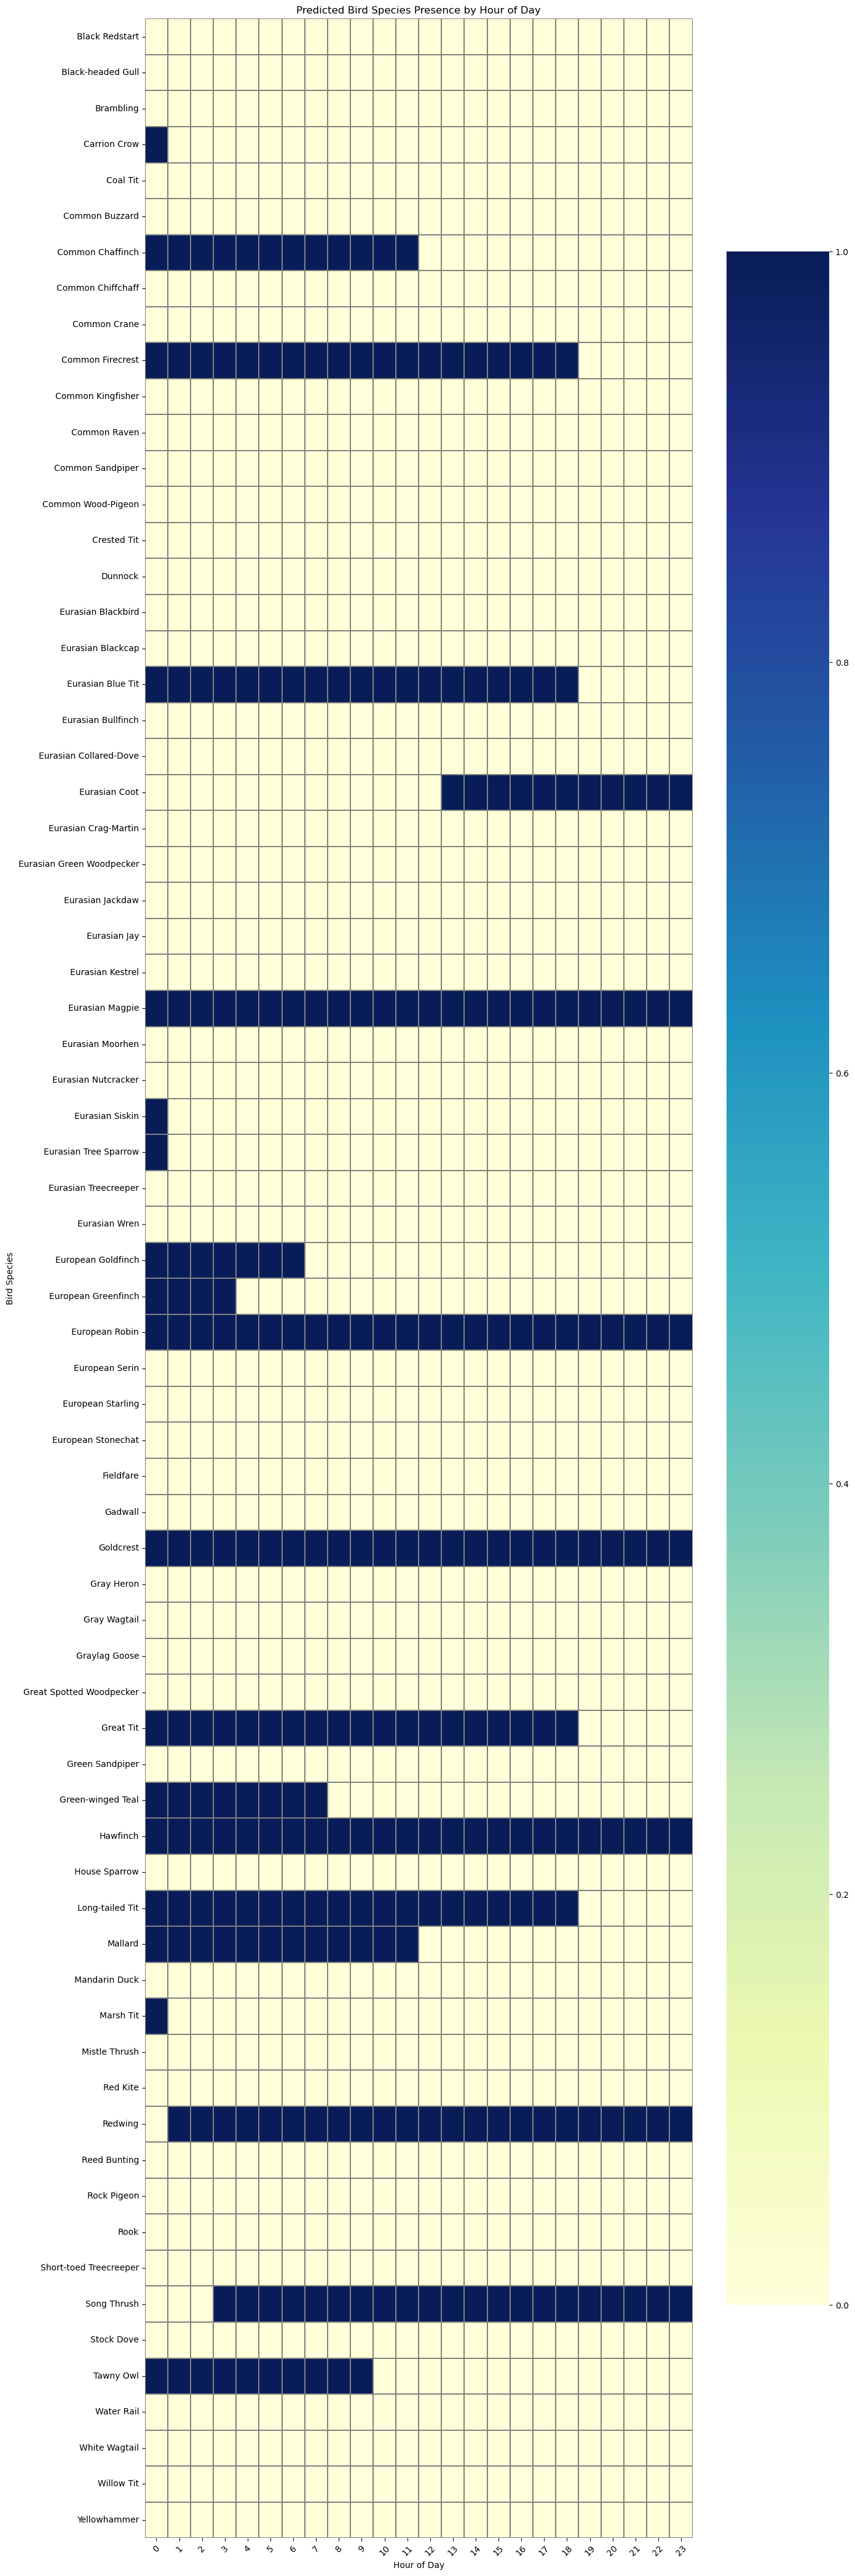

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Collect all predictions into a single Pandas DataFrame
all_preds = []

for species_name, predictions_df in results:
    # Get only hour and prediction columns
    pd_df = predictions_df.select("hour", "prediction").toPandas()
    pd_df["species"] = species_name
    all_preds.append(pd_df)

# Combine into one DataFrame
preds_df = pd.concat(all_preds)

# Pivot to make heatmap table: rows = species, columns = hours
heatmap_data = preds_df.pivot_table(index="species", columns="hour", values="prediction", aggfunc="max").fillna(0)

# Plot heatmap
plt.figure(figsize=(14, len(heatmap_data) * 0.6))
sns.heatmap(heatmap_data, cmap="YlGnBu", cbar=True, linewidths=0.3, linecolor='gray')

plt.title("Predicted Bird Species Presence by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Bird Species")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()